In [1]:
import os
import time
import math
import json
import logging
import datetime
import yfinance as yf
from datetime import datetime, timedelta
from typing import List, Dict
import torch.nn.functional as F
import requests
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from newspaper import Article, Config
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from urllib.parse import urlparse
from scipy.stats import ttest_ind
try:
    from statsmodels.nonparametric.smoothers_lowess import lowess
    from statsmodels.tsa.stattools import grangercausalitytests
    STATSMODELS_AVAILABLE = True
except ImportError:
    STATSMODELS_AVAILABLE = False
    print("Warning: statsmodels not available. Some features will be disabled.")
try:
    import ruptures as rpt
    RUPTURES_AVAILABLE = True
except ImportError:
    RUPTURES_AVAILABLE = False
    print("Warning: ruptures not available. Structural break detection will be disabled.")


logging.basicConfig(level=logging.INFO, format="%(asctime)s %(levelname)s %(message)s")

### Configuration:

In [3]:
QUERY = "Bitcoin"
YEARS_BACK = 2
GDELT_BASE = "https://api.gdeltproject.org/api/v2/doc/doc"
OUT_PARQUET = f"gdelt_{QUERY}_2yrs_finbert.parquet"
OUT_WEEKLY_PNG = f"gdelt_{QUERY}_2yrs_weekly_sentiment.png"
MODEL_NAME = "yiyanghkust/finbert-tone"
MAX_PER_CALL = 250
PAUSE_BETWEEN_CALLS = 5  # FIXED: GDELT requires 5 seconds minimum
PAUSE_BETWEEN_DOWNLOADS = 0.5
MAX_ARTICLE_CHUNKS = 6
CHUNK_CHARS = 1000
END_DATE = datetime.utcnow()
START_DATE = END_DATE - timedelta(days=365 * YEARS_BACK)
TEMP_META = 'gdelt_query_urls.jsonl'
RANDOM_STATE = 42
ARTICLES_PER_WEEK = 10

print('Config set. Query:', QUERY)

Config set. Query: Bitcoin


### Functions for GDELT querying:

In [4]:
def gdelt_datefmt(dt: datetime) -> str:
    """Convert datetime to GDELT format."""
    return dt.strftime('%Y%m%d%H%M%S')


def query_gdelt(query: str, start_dt: datetime, end_dt: datetime, maxrecords: int = MAX_PER_CALL):
    """Query GDELT API for articles."""
    params = {
        'quupdateery': query,
        'mode': 'artlist',
        'maxrecords': maxrecords,
        'format': 'json',
        'startdatetime': gdelt_datefmt(start_dt),
        'enddatetime': gdelt_datefmt(end_dt),
        'sort': 'datedesc'
    }
    try:
        resp = requests.get(GDELT_BASE, params=params, timeout=60)
        if resp.status_code != 200:
            logging.warning('GDELT query failed: %s -> %s', resp.status_code, resp.text[:200])
            return None
        return resp.json()
    except requests.exceptions.RequestException as e:
        logging.error(f'GDELT request exception: {e}')
        return None


def query_gdelt_with_retry(query: str, start_dt: datetime, end_dt: datetime,
                           maxrecords: int = MAX_PER_CALL, max_retries: int = 3):
    """Query GDELT with retry logic."""
    for attempt in range(max_retries):
        result = query_gdelt(query, start_dt, end_dt, maxrecords)
        if result is not None:
            return result
        if attempt < max_retries - 1:
            wait_time = (attempt + 1) * 5
            logging.warning(f'Retrying GDELT query in {wait_time}s (attempt {attempt+1}/{max_retries})')
            time.sleep(wait_time)
    logging.error(f'GDELT query failed after {max_retries} attempts')
    return None

In [5]:
# Helper function to iterate month windows

def iterate_month_windows(start: datetime, end: datetime):
    """Generate month-by-month windows between start and end dates."""
    cur = datetime(start.year, start.month, 1)
    while cur < end:
        if cur.month == 12:
            nxt = datetime(cur.year + 1, 1, 1)
        else:
            nxt = datetime(cur.year, cur.month + 1, 1)
        yield cur, min(nxt - timedelta(seconds=1), end)
        cur = nxt

In [6]:
# Main function to fetch all GDELT URLs with resume capability 

def fetch_all_gdelt_urls(query: str, start: datetime, end: datetime, out_meta_file: str = TEMP_META):
    """Query GDELT month-by-month and write metadata as JSONL for resume capability."""
    seen_urls = set()

    # Resume if meta file exists
    if os.path.exists(out_meta_file):
        logging.info("Resuming: loading existing metadata to avoid re-fetching")
        with open(out_meta_file, "r", encoding="utf-8") as f:
            for line in f:
                try:
                    o = json.loads(line)
                    seen_urls.add(o.get("url"))
                except (json.JSONDecodeError, KeyError) as e:
                    logging.debug(f"Skipping malformed line: {e}")
                    continue

    with open(out_meta_file, "a", encoding="utf-8") as out:
        for wstart, wend in iterate_month_windows(start, end):
            logging.info("Querying GDELT for %s -> %s", wstart.date(), wend.date())
            resp = query_gdelt_with_retry(query, wstart, wend)
            time.sleep(PAUSE_BETWEEN_CALLS)

            if not resp:
                continue

            articles = resp.get("articles") or resp.get("artlist") or []
            logging.info("Found %d articles in this window", len(articles))

            for a in articles:
                url = a.get("url") or a.get("sourceurl") or a.get("documentidentifier")
                title = a.get("title") or a.get("urltitle") or ""
                seendate = a.get("seendate") or a.get("date") or a.get("published")

                if not url or url in seen_urls:
                    continue

                seen_urls.add(url)
                record = {"url": url, "title": title, "seendate": seendate}
                out.write(json.dumps(record, ensure_ascii=False) + "\n")

    logging.info("GDELT URL fetching complete. Total unique URLs: %d", len(seen_urls))
    return out_meta_file

In [7]:
# Function to load URLs from metadata file

def load_urls_from_meta(meta_file: str):
    """Load article metadata from JSONL file."""
    rows = []
    with open(meta_file, "r", encoding="utf-8") as f:
        for line in f:
            try:
                rows.append(json.loads(line))
            except (json.JSONDecodeError, ValueError) as e:
                logging.debug(f"Skipping invalid JSON line: {e}")
                continue
    return rows

In [8]:
# Function to extract text using newspaper3k 

def extract_text_with_newspaper(url: str, fallback_text: str = ""):
    """Extract article text using newspaper3k with proper timeout configuration."""
    try:
        config = Config()
        config.browser_user_agent = 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36'
        config.request_timeout = 15
        config.number_threads = 1

        art = Article(url, config=config, language='en')
        art.download()
        art.parse()
        return art.title or None, art.text or None, (art.publish_date if hasattr(art, "publish_date") else None)
    except Exception as e:
        logging.debug(f"Article extraction failed for {url}: {type(e).__name__}")
        return None, fallback_text or None, None


def chunk_text(text: str, max_chars=CHUNK_CHARS):
    """Split text into chunks based on character limit."""
    if not text:
        return []
    text = text.strip()
    if len(text) <= max_chars:
        return [text]

    sentences = text.split('. ')
    chunks = []
    cur, cur_len = [], 0

    for s in sentences:
        s_len = len(s) + 2
        if cur_len + s_len > max_chars and cur:
            chunks.append('. '.join(cur).strip() + ('.' if not cur[-1].endswith('.') else ''))
            cur = [s]
            cur_len = s_len
        else:
            cur.append(s)
            cur_len += s_len

    if cur:
        chunks.append('. '.join(cur).strip() + ('.' if not cur[-1].endswith('.') else ''))

    return chunks

In [9]:
#  Function to safely save DataFrame to Parquet with error handling 
def safe_to_parquet(df, path, **kwargs):
    """Safely save to parquet with ArrowKeyError handling."""
    import warnings
    try:
        df.to_parquet(path, engine='pyarrow', **kwargs)
    except Exception as e:
        if "pandas.period" in str(e) or "ArrowKeyError" in str(e):
            logging.warning("Using fastparquet due to period type conflict")
            try:
                df.to_parquet(path, engine='fastparquet', **kwargs)
            except ImportError:
                logging.error("fastparquet not installed. Run: pip install fastparquet")
                raise
        else:
            raise

def sanitize_df_for_parquet(df, convert_period_to='timestamp'):
    """Enhanced version with warning suppression and Period detection."""
    import warnings
    df = df.copy()

    # Handle PeriodIndex
    if isinstance(df.index, pd.PeriodIndex):
        df.index = df.index.to_timestamp() if convert_period_to == 'timestamp' else df.index.astype(str)

    for col in df.columns:
        col_dtype = df[col].dtype
        col_lower = col.lower()

        # Date/time columns with warning suppression
        if any(token in col_lower for token in ("date", "time", "published")):
            try:
                with warnings.catch_warnings():
                    warnings.filterwarnings('ignore', message='Could not infer format')
                    parsed = pd.to_datetime(df[col], errors='coerce', utc=True)
                if parsed.notna().any():
                    df[col] = parsed
                else:
                    df[col] = df[col].astype(str)
                continue
            except:
                df[col] = df[col].astype(str)
                continue

        # Handle PeriodDtype columns
        try:
            from pandas import PeriodDtype
            if isinstance(col_dtype, PeriodDtype):
                df[col] = df[col].dt.to_timestamp() if convert_period_to == 'timestamp' else df[col].astype(str)
                continue
        except:
            pass

        # Handle object columns
        if col_dtype == object:
            sample = df[col].dropna().head(50)

            # Check for Period objects
            if not sample.empty and any(isinstance(x, pd.Period) for x in sample):
                df[col] = df[col].apply(
                    lambda p: p.to_timestamp() if isinstance(p, pd.Period) else p
                ) if convert_period_to == 'timestamp' else df[col].astype(str)
                continue

            # Auto-detect datetime strings with warning suppression
            str_sample = sample.astype(str).str.strip().head(20)
            if len(str_sample) > 0:
                with warnings.catch_warnings():
                    warnings.filterwarnings('ignore', message='Could not infer format')
                    parsed_sample = pd.to_datetime(str_sample, errors='coerce', utc=True)

                if parsed_sample.notna().sum() / max(1, len(str_sample)) > 0.4:
                    try:
                        with warnings.catch_warnings():
                            warnings.filterwarnings('ignore', message='Could not infer format')
                            df[col] = pd.to_datetime(df[col], errors='coerce', utc=True)
                        continue
                    except:
                        pass

            df[col] = df[col].astype(str)

    return df

In [10]:
# Function to load FinBERT model and tokenizer 

def load_finbert_model(model_name: str = MODEL_NAME):
    """Load FinBERT tokenizer and model."""
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    logging.info(f"Loading FinBERT model on {device}")

    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name)
    model.to(device)
    model.eval()

    return tokenizer, model, device


def predict_article_sentiment(tokenizer, model, device, title, text,
                              chunk_chars=CHUNK_CHARS, max_chunks=MAX_ARTICLE_CHUNKS,
                              batch_size=8, max_length=512):
    """
    Predict sentiment for an article using FinBERT.
    Returns dict with avg_probs, final_label, and n_pieces.
    """
    # Build pieces (title + text chunks)
    pieces = []
    if title:
        pieces.append(title)
    if text:
        chunks = chunk_text(text, chunk_chars)
        pieces.extend(chunks)

    if not pieces:
        return None

    pieces = pieces[:max_chunks]

    # Batch process
    all_probs = []
    label_names = None

    try:
        for i in range(0, len(pieces), batch_size):
            batch_texts = pieces[i:i+batch_size]
            inputs = tokenizer(batch_texts, return_tensors="pt", truncation=True,
                             padding=True, max_length=max_length)
            inputs = {k: v.to(device) for k, v in inputs.items()}

            with torch.no_grad():
                outputs = model(**inputs)
                logits = outputs.logits
                probs = F.softmax(logits, dim=-1).cpu().numpy()

            # Get label names
            if label_names is None:
                try:
                    id2lab = model.config.id2label
                    label_names = [id2lab[i].lower() for i in range(len(id2lab))]
                except Exception:
                    label_names = ['positive', 'neutral', 'negative'] if probs.shape[1] == 3 else [f"lab_{j}" for j in range(probs.shape[1])]

            # Store probabilities
            for row in probs:
                all_probs.append({label_names[j]: float(row[j]) for j in range(len(row))})

    except Exception as e:
        logging.error(f"Sentiment prediction failed: {type(e).__name__} - {e}")
        return None

    # Aggregate: mean probability per label
    agg = {}
    for d in all_probs:
        for k, v in d.items():
            agg.setdefault(k, []).append(v)

    avg_probs = {k: float(np.mean(vlist)) for k, vlist in agg.items()}

    # Ensure all expected labels exist
    for k in ["positive", "neutral", "negative"]:
        avg_probs.setdefault(k, 0.0)

    final_label = max(avg_probs.items(), key=lambda kv: kv[1])[0]

    return {"avg_probs": avg_probs, "final_label": final_label, "n_pieces": len(all_probs)}


In [10]:
# === STEP 1: Fetch GDELT article URLs ===

logging.info("=" * 60)
logging.info("STEP 1: Fetching GDELT article URLs")
logging.info("=" * 60)

meta_file = fetch_all_gdelt_urls(QUERY, START_DATE, END_DATE, TEMP_META)
print(f'Meta saved to {meta_file}')

2026-01-22 17:05:04,205 INFO ============================================================
2026-01-22 17:05:04,207 INFO STEP 1: Fetching GDELT article URLs
2026-01-22 17:05:04,209 INFO ============================================================
2026-01-22 17:05:04,212 INFO Resuming: loading existing metadata to avoid re-fetching
2026-01-22 17:05:04,244 INFO Querying GDELT for 2024-01-01 -> 2024-01-31
2026-01-22 17:05:05,021 ERROR GDELT request exception: Expecting value: line 1 column 1 (char 0)
2026-01-22 17:05:05,022 WARNING Retrying GDELT query in 5s (attempt 1/3)
2026-01-22 17:05:10,933 ERROR GDELT request exception: Expecting value: line 1 column 1 (char 0)
2026-01-22 17:05:10,934 WARNING Retrying GDELT query in 10s (attempt 2/3)
2026-01-22 17:05:21,809 ERROR GDELT request exception: Expecting value: line 1 column 1 (char 0)
2026-01-22 17:05:21,810 ERROR GDELT query failed after 3 attempts
2026-01-22 17:05:26,812 INFO Querying GDELT for 2024-02-01 -> 2024-02-29
2026-01-22 17:05:27

2026-01-22 17:10:03,098 WARNING Retrying GDELT query in 5s (attempt 1/3)
2026-01-22 17:10:08,999 ERROR GDELT request exception: Expecting value: line 1 column 1 (char 0)
2026-01-22 17:10:08,999 WARNING Retrying GDELT query in 10s (attempt 2/3)
2026-01-22 17:10:19,854 ERROR GDELT request exception: Expecting value: line 1 column 1 (char 0)
2026-01-22 17:10:19,855 ERROR GDELT query failed after 3 attempts
2026-01-22 17:10:24,861 INFO Querying GDELT for 2025-03-01 -> 2025-03-31
2026-01-22 17:10:25,792 ERROR GDELT request exception: Expecting value: line 1 column 1 (char 0)
2026-01-22 17:10:25,793 WARNING Retrying GDELT query in 5s (attempt 1/3)
2026-01-22 17:10:31,731 ERROR GDELT request exception: Expecting value: line 1 column 1 (char 0)
2026-01-22 17:10:31,732 WARNING Retrying GDELT query in 10s (attempt 2/3)
2026-01-22 17:10:42,619 ERROR GDELT request exception: Expecting value: line 1 column 1 (char 0)
2026-01-22 17:10:42,620 ERROR GDELT query failed after 3 attempts
2026-01-22 17:10

Meta saved to gdelt_query_urls.jsonl


In [11]:
# === STEP 2: Load and sample metadata ===

logging.info("=" * 60)
logging.info("STEP 2: Loading and sampling metadata")
logging.info("=" * 60)

meta_rows = load_urls_from_meta(TEMP_META)
meta_df = pd.DataFrame(meta_rows)
meta_df['url'] = meta_df['url'].astype(str)
meta_df.drop_duplicates(subset=['url'], inplace=True)
print(f'Total unique URLs: {len(meta_df)}')

2026-01-22 17:14:34,616 INFO ============================================================
2026-01-22 17:14:34,617 INFO STEP 2: Loading and sampling metadata
2026-01-22 17:14:34,619 INFO ============================================================


Total unique URLs: 6282


In [12]:
# Parse seendate and drop invalid entries 

meta_df['seendate_parsed'] = pd.to_datetime(meta_df['seendate'], errors='coerce', utc=True)
meta_df = meta_df.dropna(subset=['seendate_parsed'])

# FIXED: Use to_timestamp() to avoid PeriodIndex issues
meta_df['week'] = meta_df['seendate_parsed'].dt.to_period('W-MON').dt.to_timestamp()

# Sample articles per week
sampled_df = meta_df.groupby('week').apply(
    lambda g: g.sample(n=min(len(g), ARTICLES_PER_WEEK), random_state=RANDOM_STATE)
).reset_index(drop=True)

print(f"Selected {len(sampled_df)} articles ({sampled_df['week'].nunique()} weeks)")
meta_df = sampled_df

Selected 250 articles (25 weeks)


/tmp/ipykernel_2032494/4093820290.py:7: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  meta_df['week'] = meta_df['seendate_parsed'].dt.to_period('W-MON').dt.to_timestamp()


In [11]:
# Extract text and run FinBERT

logging.info("=" * 60)
logging.info("STEP 3: Extracting text and analyzing sentiment")
logging.info("=" * 60)

# Load existing results for resume
done_df = pd.DataFrame()
if os.path.exists(OUT_PARQUET):
    logging.info(f'Loading existing parquet {OUT_PARQUET} for resume')
    done_df = pd.read_parquet(OUT_PARQUET)

2026-01-22 18:15:09,930 INFO ============================================================
2026-01-22 18:15:09,938 INFO STEP 3: Extracting text and analyzing sentiment
2026-01-22 18:15:09,939 INFO ============================================================
2026-01-22 18:15:09,940 INFO Loading existing parquet gdelt_Bitcoin_2yrs_finbert.parquet for resume


In [12]:
# Prepare set of processed URLs for quick lookup

# FIXED: Use set for O(1) lookup instead of O(n)
processed_urls = set(done_df['url'].values) if not done_df.empty else set()

# Load FinBERT model
tokenizer, model, device = load_finbert_model(MODEL_NAME)

new_rows = []

for idx, r in tqdm(meta_df.iterrows(), total=len(meta_df), desc='Processing articles'):
    url = r['url']

    # FIXED: O(1) lookup
    if url in processed_urls:
        continue

    title_meta = r.get('title') or ''
    title, text, pubdate = extract_text_with_newspaper(url, fallback_text=title_meta)
    time.sleep(PAUSE_BETWEEN_DOWNLOADS)

    if not title and not text:
        logging.info(f'No content for url {url} (skipping)')
        continue

    pred = predict_article_sentiment(tokenizer, model, device, title or title_meta, text or '')
    if pred is None:
        continue

    avg_probs = pred['avg_probs']
    rec = {
        'url': url,
        'rss_title': title_meta,
        'title': title,
        'published_raw': pubdate if pubdate else r.get('seendate'),
        'sent_label': pred['final_label'],
        'prob_positive': avg_probs.get('positive', 0.0),
        'prob_neutral': avg_probs.get('neutral', 0.0),
        'prob_negative': avg_probs.get('negative', 0.0),
        'n_pieces': pred['n_pieces']
    }
    new_rows.append(rec)
    processed_urls.add(url)  # FIXED: Add to set

    # Save every 50 articles
    if len(new_rows) >= 50:
        logging.info(f'Checkpoint: Saving {len(new_rows)} new rows ({len(done_df) + len(new_rows)} total)')
        chunk_df = pd.DataFrame(new_rows)
        done_df = pd.concat([done_df, chunk_df], ignore_index=True) if not done_df.empty else chunk_df.copy()
        safe_df = sanitize_df_for_parquet(done_df, convert_period_to='timestamp')
        safe_to_parquet(safe_df, OUT_PARQUET, index=False)
        new_rows = []

# Final save
if new_rows:
    logging.info(f'Final save: {len(new_rows)} new rows')
    chunk_df = pd.DataFrame(new_rows)
    done_df = pd.concat([done_df, chunk_df], ignore_index=True) if not done_df.empty else chunk_df.copy()
    safe_df = sanitize_df_for_parquet(done_df, convert_period_to='timestamp')
    safe_to_parquet(safe_df, OUT_PARQUET, index=False)

logging.info(f'Finished extraction & prediction; total articles: {len(done_df)}')


2026-01-22 18:15:17,751 INFO Loading FinBERT model on cpu


NameError: name 'meta_df' is not defined

In [13]:
# Generate weekly sentiment plot
logging.info("=" * 60)
logging.info("STEP 4: Generating weekly sentiment plot")
logging.info("=" * 60)

if 'done_df' not in locals() or done_df.empty:
    if os.path.exists(OUT_PARQUET):
        done_df = pd.read_parquet(OUT_aPARQUET)
    else:
        raise FileNotFoundError('No prediction parquet found')

2026-01-22 18:15:25,536 INFO ============================================================
2026-01-22 18:15:25,538 INFO STEP 4: Generating weekly sentiment plot
2026-01-22 18:15:25,538 INFO ============================================================


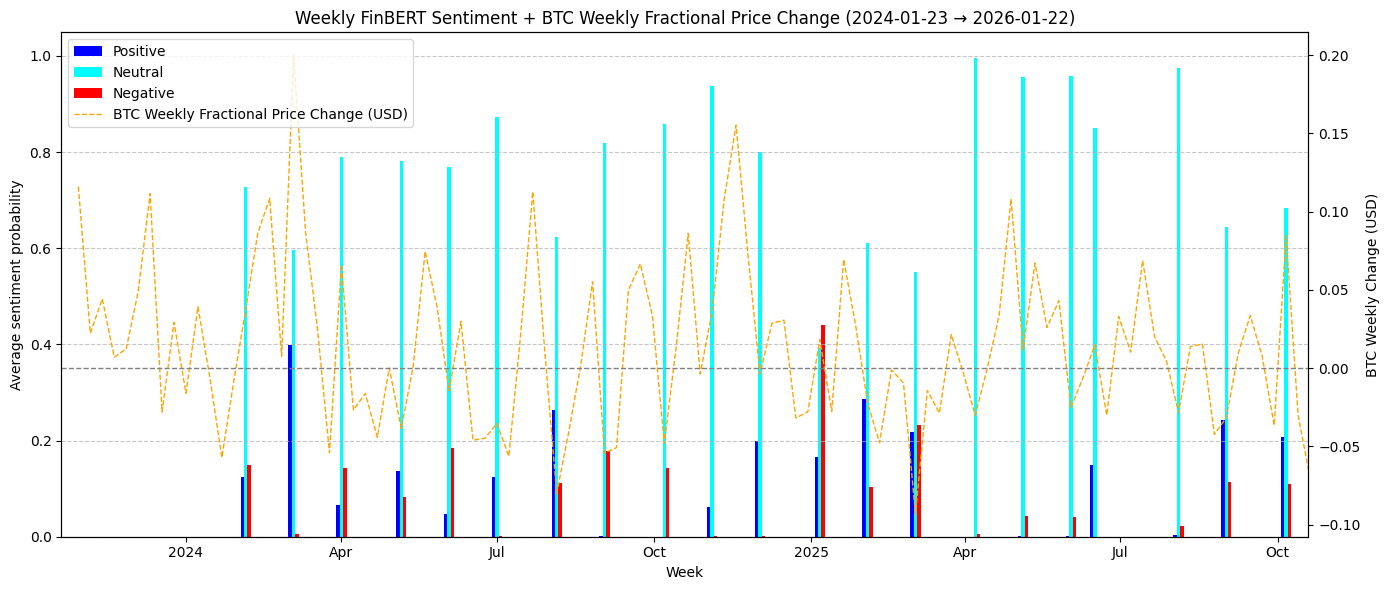

In [14]:
# Define x-axis range
start_date = pd.Timestamp("2023-10-20", tz='UTC')
end_date   = pd.Timestamp("2025-10-19", tz='UTC')

# Disable LaTeX rendering to suppress font warnings
mpl.rcParams['text.usetex'] = False
# Disable tokenizers parallelism warning
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Load the model output (reuse in-memory results if available)
try:
    df = done_df.copy()
except NameError:
    df = pd.read_parquet(OUT_PARQUET)

# Ensure datetime and index
# Handle case where published_raw might already be a datetime object with timezone
# Convert to string first to avoid timezone parsing issues, then parse
if pd.api.types.is_datetime64_any_dtype(df['published_raw']):
    # Already a datetime, work with it directly
    df['published'] = df['published_raw'].copy()
    # Ensure UTC timezone
    if df['published'].dt.tz is None:
        df['published'] = df['published'].dt.tz_localize('UTC')
    else:
        df['published'] = df['published'].dt.tz_convert('UTC')
elif df['published_raw'].dtype == 'object':
    # Check if it contains datetime objects (not datetime64)
    # Convert to string first to avoid timezone parsing issues
    df['published'] = pd.to_datetime(df['published_raw'].astype(str), errors='coerce', utc=True)
else:
    # Parse from string
    df['published'] = pd.to_datetime(df['published_raw'], errors='coerce', utc=True)
df = df.dropna(subset=['published'])
df = df.set_index('published').sort_index()

# Compute weekly sentiment averages (Monday-anchored)
weekly = df[['prob_positive', 'prob_neutral', 'prob_negative']].resample('W-MON').mean().sort_index()

btc = yf.download("BTC-USD", start="2023-10-20", end="2025-10-20", progress=False)
btc.index = pd.to_datetime(btc.index).tz_localize('UTC')

# Resample to weekly closing price (Monday)
btc_weekly = btc['Close'].resample('W-MON').mean()

# Compute weekly change in price (Δ price = current week - previous week)
btc_weekly_change = btc_weekly.diff()
btc_weekly_change = btc_weekly.pct_change()  # percentage change

fig, ax = plt.subplots(figsize=(14, 6))

# Weekly bar width and offset
bar_width = pd.Timedelta(days=2)
offset = pd.Timedelta(days=2)
x = weekly.index

# Plot sentiment grouped bars
ax.bar(x - offset, weekly['prob_positive'], width=bar_width, label='Positive', color='blue')
ax.bar(x,          weekly['prob_neutral'],  width=bar_width, label='Neutral',  color='cyan')
ax.bar(x + offset, weekly['prob_negative'], width=bar_width, label='Negative', color='red')

# Left axis: sentiment
ax.set_xlabel('Week')
ax.set_ylabel('Average sentiment probability')
ax.set_title(f"Weekly FinBERT Sentiment + BTC Weekly Fractional Price Change ({START_DATE.date()} → {END_DATE.date()})")
ax.grid(True, axis='y', linestyle='--', alpha=0.7)
ax.set_xlim([start_date, end_date])

# X-axis formatting
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

ax2 = ax.twinx()
ax2.plot(btc_weekly_change.index, btc_weekly_change, label='BTC Weekly Fractional Price Change (USD)', color='orange', linewidth=1, ls='--')
ax2.axhline(0, color='gray', linestyle='--', linewidth=1)  # zero-line
ax2.set_ylabel('BTC Weekly Change (USD)', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Combine legends
lines_1, labels_1 = ax.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax2.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

plt.tight_layout()
# plt.savefig(OUT_WEEKLY_PNG.replace('.png', '_btc_change_overlay.png'), dpi=150)
plt.show()


## Statistical Robustness Analysis

The following sections add statistical rigor to the sentiment analysis pipeline:
- Bootstrap confidence intervals
- Article length weighting
- Outlet dominance diagnostics
- Time-series smoothing
- Structural break detection
- Hypothesis testing
- Robustness checks

In [ ]:
# ============================================================================
# 1. BOOTSTRAP CONFIDENCE INTERVALS FOR WEEKLY SENTIMENT
# ============================================================================
# INTERPRETATION: How confident are we about weekly Bitcoin sentiment inferred from GDELT news?

def bootstrap_ci(x, n_boot=2000, alpha=0.05):
    """
    Compute bootstrap confidence intervals for a sample.
    
    Parameters:
    -----------
    x : array-like
        Sample data
    n_boot : int
        Number of bootstrap samples
    alpha : float
        Significance level (0.05 = 95% CI)
    
    Returns:
    --------
    tuple : (lower_bound, upper_bound)
    """
    x = np.asarray(x)
    if len(x) < 3:
        return np.nan, np.nan
    
    means = np.random.choice(x, (n_boot, len(x)), replace=True).mean(axis=1)
    lo = np.percentile(means, 100 * alpha/2)
    hi = np.percentile(means, 100 * (1 - alpha/2))
    return lo, hi

# Prepare weekly data with week column for grouping
df['week'] = df.index.to_period('W-MON').to_timestamp()

# Compute weekly aggregates with confidence intervals
weekly_stats = df.groupby('week').agg({
    'prob_positive': ['mean', 'std', 'size'],
    'prob_neutral': 'mean',
    'prob_negative': 'mean',
    'n_pieces': 'mean'
}).round(4)

weekly_stats.columns = ['mean_pos', 'std_pos', 'n_articles', 'mean_neu', 'mean_neg', 'mean_pieces']

# Compute bootstrap CIs for positive sentiment
print("Computing bootstrap confidence intervals...")
cis = df.groupby('week')['prob_positive'].apply(
    lambda s: bootstrap_ci(s.values, n_boot=2000, alpha=0.05)
)

weekly_stats['ci_low'] = cis.apply(lambda x: x[0] if isinstance(x, tuple) else np.nan)
weekly_stats['ci_high'] = cis.apply(lambda x: x[1] if isinstance(x, tuple) else np.nan)
weekly_stats['ci_width'] = weekly_stats['ci_high'] - weekly_stats['ci_low']

print(f"\nWeekly Statistics Summary:")
print(f"Mean articles per week: {weekly_stats['n_articles'].mean():.1f}")
print(f"Mean CI width: {weekly_stats['ci_width'].mean():.4f}")
print(f"Weeks with <5 articles: {(weekly_stats['n_articles'] < 5).sum()}")
weekly_stats.head(10)

Computing bootstrap confidence intervals...

Weekly Statistics Summary:
Mean articles per week: 5.6
Mean CI width: 0.2687
Weeks with <5 articles: 10


/tmp/ipykernel_2621954/4001939297.py:32: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['week'] = df.index.to_period('W-MON').to_timestamp()


,mean_pos,std_pos,n_articles,mean_neu,mean_neg,mean_pieces,ci_low,ci_high,ci_width
week,,,,,,,,,
2024-01-30,0.1236,0.2898,10,0.7268,0.1495,2.3000,0.000236,0.309197,0.308961
2024-02-27,0.3991,0.5444,5,0.5959,0.0050,1.8000,0.001220,0.797089,0.795869
2024-03-26,0.0663,0.1965,9,0.7898,0.1439,1.8889,0.000250,0.197598,0.197348
2024-04-30,0.1364,0.3503,8,0.7808,0.0828,2.5000,0.000232,0.386640,0.386407
2024-05-28,0.0472,0.0901,9,0.7691,0.1837,2.3333,0.001367,0.113317,0.111950
2024-06-25,0.1250,0.3534,8,0.8738,0.0012,2.0000,0.000002,0.374917,0.374915
2024-07-30,0.2644,0.3813,7,0.6243,0.1113,2.7143,0.050065,0.547702,0.497638
2024-08-27,0.0019,0.0039,8,0.8189,0.1791,2.0000,0.000021,0.004648,0.004627
2024-10-01,0.0001,0.0001,7,0.8579,0.1420,1.8571,0.000009,0.000196,0.000188


Weighted vs Unweighted Sentiment Comparison:
Mean absolute difference: 0.0323
Max absolute difference: 0.2080

Correlation: 0.9254


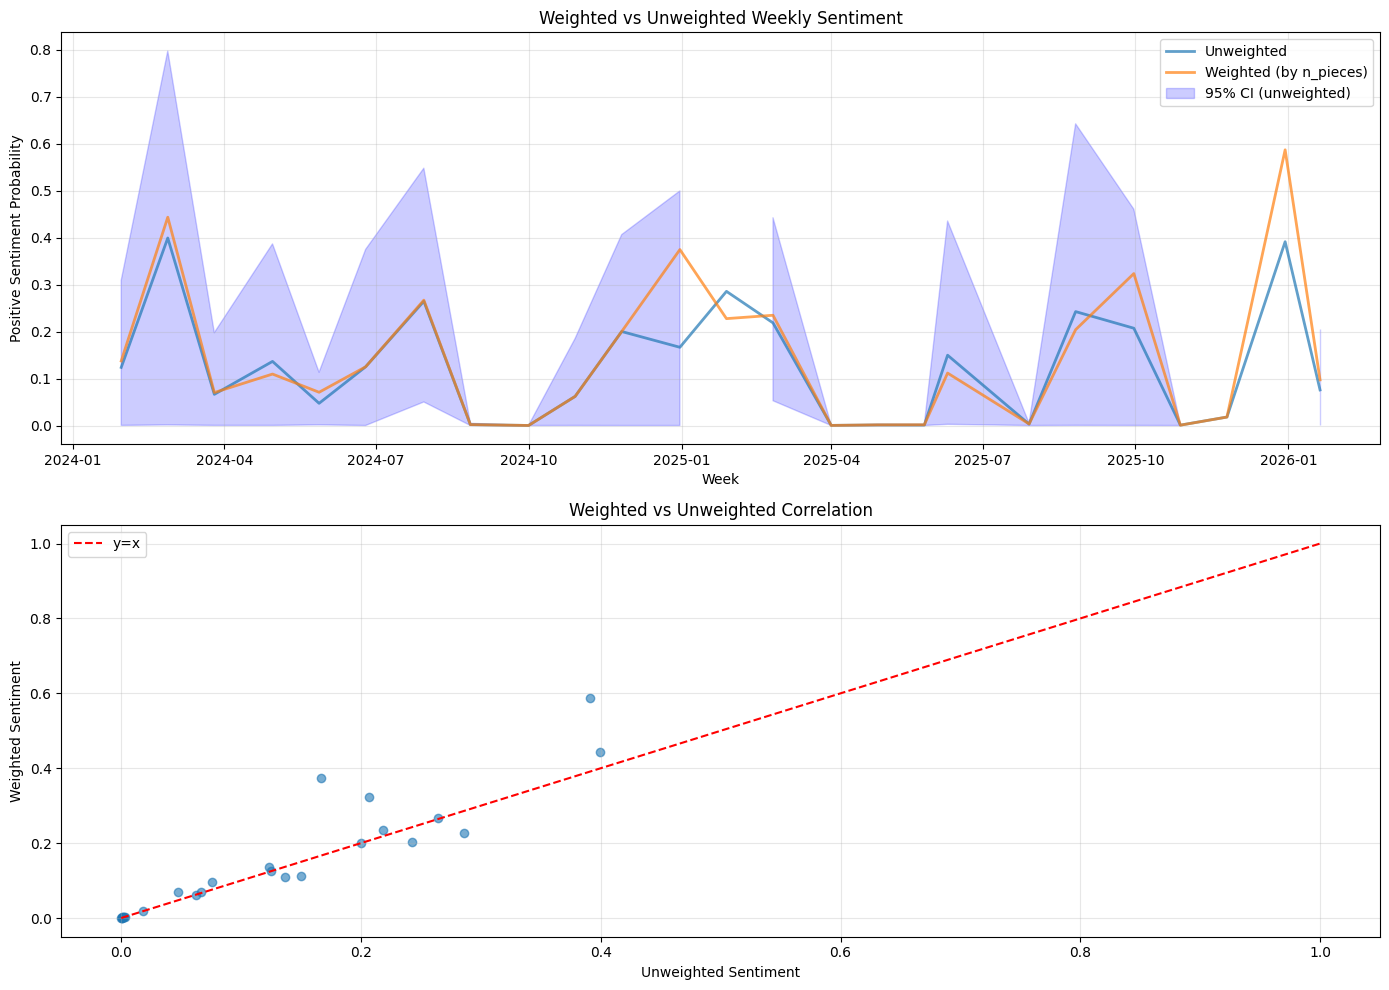

,unweighted,weighted,difference
week,,,
2024-01-30,0.123646,0.137391,0.013745
2024-02-27,0.399111,0.443372,0.044260
2024-03-26,0.066317,0.070176,0.003860
2024-04-30,0.136432,0.109516,-0.026916
2024-05-28,0.047215,0.070746,0.023531
2024-06-25,0.125004,0.125004,0.000000
2024-07-30,0.264438,0.266870,0.002432
2024-08-27,0.001915,0.001915,0.000000
2024-10-01,0.000088,0.000095,0.000007


In [ ]:
# ============================================================================
# 2. ARTICLE LENGTH WEIGHTING
# ============================================================================
# INTERPRETATION: Does weekly Bitcoin sentiment change if longer articles are given more influence than short ones?

# Weight by article length (n_pieces)
df['weight'] = df['n_pieces'].clip(1, 6)

# Compute weighted and unweighted weekly averages
weekly_weighted = df.groupby('week').apply(
    lambda g: np.average(g['prob_positive'], weights=g['weight'])
)

weekly_unweighted = df.groupby('week')['prob_positive'].mean()

# Compare weighted vs unweighted
comparison = pd.DataFrame({
    'unweighted': weekly_unweighted,
    'weighted': weekly_weighted,
    'difference': weekly_weighted - weekly_unweighted
})

print("Weighted vs Unweighted Sentiment Comparison:")
print(f"Mean absolute difference: {comparison['difference'].abs().mean():.4f}")
print(f"Max absolute difference: {comparison['difference'].abs().max():.4f}")
print(f"\nCorrelation: {comparison['unweighted'].corr(comparison['weighted']):.4f}")

# Plot comparison
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Top: Time series comparison
ax1.plot(comparison.index, comparison['unweighted'], label='Unweighted', alpha=0.7, linewidth=2)
ax1.plot(comparison.index, comparison['weighted'], label='Weighted (by n_pieces)', alpha=0.7, linewidth=2)
ax1.fill_between(weekly_stats.index, weekly_stats['ci_low'], weekly_stats['ci_high'], 
                 alpha=0.2, color='blue', label='95% CI (unweighted)')
ax1.set_xlabel('Week')
ax1.set_ylabel('Positive Sentiment Probability')
ax1.set_title('Weighted vs Unweighted Weekly Sentiment')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Bottom: Scatter plot
ax2.scatter(comparison['unweighted'], comparison['weighted'], alpha=0.6)
ax2.plot([0, 1], [0, 1], 'r--', label='y=x')
ax2.set_xlabel('Unweighted Sentiment')
ax2.set_ylabel('Weighted Sentiment')
ax2.set_title('Weighted vs Unweighted Correlation')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

comparison.head(10)

Very strong correlation. Longer and shorter articles agree.

Outlet Dominance Diagnostics:
Weeks with single outlet >40%: 5
Percentage of weeks with high concentration: 20.0%

Most common dominant domains:
dominant_domain
biztoc.com                      4
www.dailypolitical.com          3
economictimes.indiatimes.com    2
www.benzinga.com                2
finance.yahoo.com               2
eladelantado.com                1
actualidad.rt.com               1
asia.nikkei.com                 1
invezz.com                      1
t24.com.tr                      1
Name: count, dtype: int64


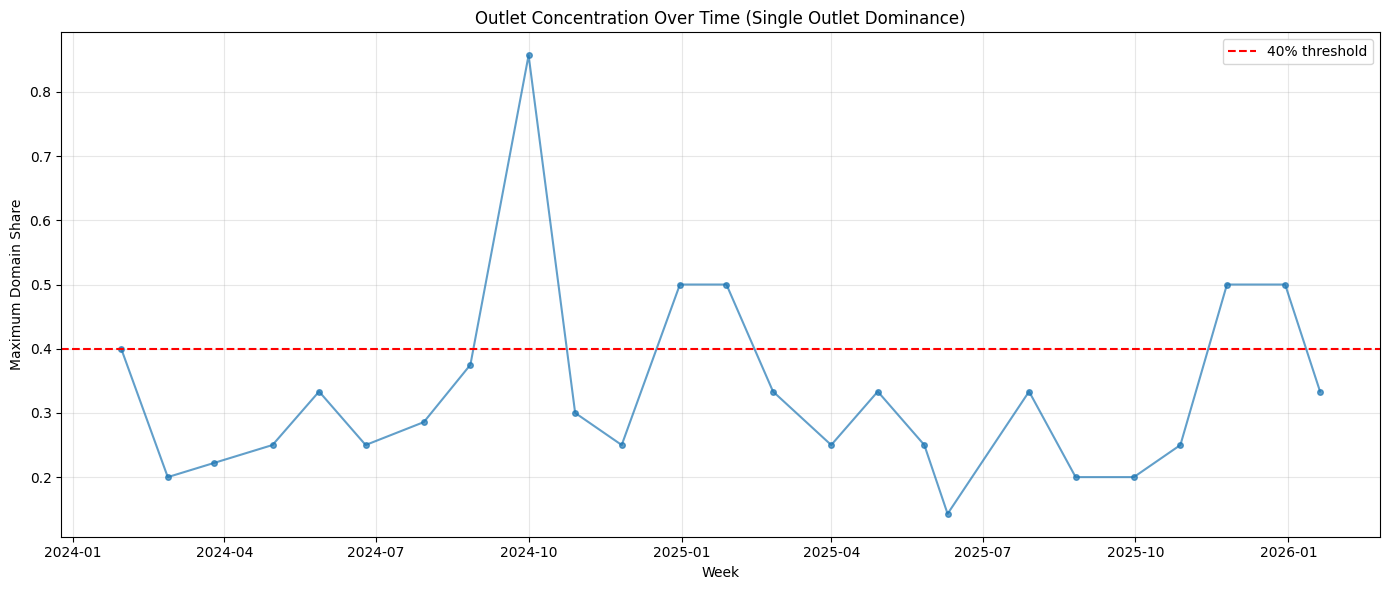

,max_domain_share,dominant_domain,high_concentration
week,,,
2024-01-30,0.400000,biztoc.com,False
2024-02-27,0.200000,biztoc.com,False
2024-03-26,0.222222,www.dailypolitical.com,False
2024-04-30,0.250000,theenterpriseleader.com,False
2024-05-28,0.333333,www.dailypolitical.com,False
2024-06-25,0.250000,biztoc.com,False
2024-07-30,0.285714,www.benzinga.com,False
2024-08-27,0.375000,www.dailypolitical.com,False
2024-10-01,0.857143,www.tickerreport.com,True


In [ ]:
# ============================================================================
# 3. OUTLET DOMINANCE DIAGNOSTICS
# ============================================================================
# INTERPRETATION: Do some news outlets dominate the sentiment analysis?

# Extract domain from URLs
df['domain'] = df['url'].apply(lambda u: urlparse(u).netloc if pd.notna(u) else 'unknown')

# Compute domain counts per week
domain_counts = df.groupby(['week', 'domain']).size().reset_index(name='count')

# Compute domain share per week
domain_share = []
for week in domain_counts['week'].unique():
    week_data = domain_counts[domain_counts['week'] == week]
    total = week_data['count'].sum()
    week_data = week_data.copy()
    week_data['share'] = week_data['count'] / total
    domain_share.append(week_data)

domain_share = pd.concat(domain_share, ignore_index=True)

# Find maximum domain share per week
max_domain_share = domain_share.groupby('week')['share'].max().reset_index()
max_domain_share.columns = ['week', 'max_domain_share']

# Identify dominant domains per week (domains with maximum share)
dominant_domains = domain_share.loc[domain_share.groupby('week')['share'].idxmax()][['week', 'domain', 'share']]
dominant_domains = dominant_domains.rename(columns={'domain': 'dominant_domain'})

# Merge with weekly stats
weekly_stats = weekly_stats.merge(max_domain_share.set_index('week'), left_index=True, right_index=True, how='left')
weekly_stats = weekly_stats.merge(dominant_domains.set_index('week'), left_index=True, right_index=True, how='left')

# Flag weeks with high outlet concentration (>40%)
weekly_stats['high_concentration'] = weekly_stats['max_domain_share'] > 0.4

print("Outlet Dominance Diagnostics:")
print(f"Weeks with single outlet >40%: {weekly_stats['high_concentration'].sum()}")
print(f"Percentage of weeks with high concentration: {weekly_stats['high_concentration'].mean()*100:.1f}%")
print(f"\nMost common dominant domains:")
print(weekly_stats['dominant_domain'].value_counts().head(10))

# Plot domain concentration over time
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(weekly_stats.index, weekly_stats['max_domain_share'], marker='o', markersize=4, alpha=0.7)
ax.axhline(0.4, color='red', linestyle='--', label='40% threshold')
ax.set_xlabel('Week')
ax.set_ylabel('Maximum Domain Share')
ax.set_title('Outlet Concentration Over Time (Single Outlet Dominance)')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

weekly_stats[['max_domain_share', 'dominant_domain', 'high_concentration']].head(15)

Approximately 20% of weeks were dominated by a single outlet contributing over 40% of sampled articles. Dominant sources were often financial news aggregators such as Biztoc and Yahoo Finance, suggesting that some weekly sentiment estimates may reflect amplified syndicated narratives rather than a broad cross-section of original reporting.

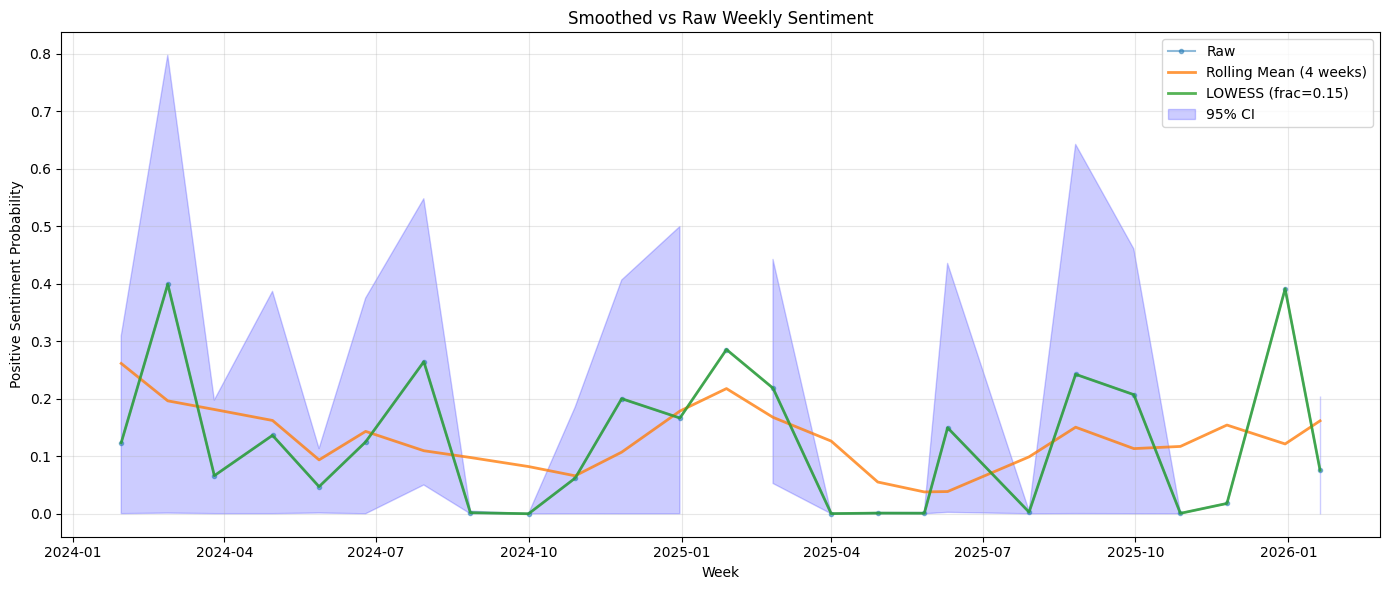

,mean_pos,smooth_rolling,smooth_lowess
week,,,
2024-01-30,0.1236,0.261350,0.1236
2024-02-27,0.3991,0.196333,0.3991
2024-03-26,0.0663,0.181350,0.0663
2024-04-30,0.1364,0.162250,0.1364
2024-05-28,0.0472,0.093725,0.0472
2024-06-25,0.1250,0.143250,0.1250
2024-07-30,0.2644,0.109625,0.2644
2024-08-27,0.0019,0.097850,0.0019
2024-10-01,0.0001,0.082100,0.0001


In [ ]:
# ============================================================================
# 4. TIME-SERIES SMOOTHING
# ============================================================================
# INTERPRETATION: How does the sentiment time series look when we smooth out sampling noise and short-term volatility?

# Simple rolling mean
weekly_stats['smooth_rolling'] = weekly_stats['mean_pos'].rolling(window=4, center=True, min_periods=1).mean()

# LOWESS smoothing (if available)
if STATSMODELS_AVAILABLE:
    # Convert index to numeric for LOWESS
    x_numeric = np.arange(len(weekly_stats))
    y_values = weekly_stats['mean_pos'].values
    
    # Apply LOWESS
    lowess_result = lowess(y_values, x_numeric, frac=0.15, it=3)
    weekly_stats['smooth_lowess'] = lowess_result[:, 1]
else:
    weekly_stats['smooth_lowess'] = weekly_stats['smooth_rolling']
    print("Note: Using rolling mean instead of LOWESS (statsmodels not available)")

# Plot smoothed vs raw
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(weekly_stats.index, weekly_stats['mean_pos'], 'o-', alpha=0.5, label='Raw', markersize=3)
ax.plot(weekly_stats.index, weekly_stats['smooth_rolling'], '-', linewidth=2, label='Rolling Mean (4 weeks)', alpha=0.8)
if STATSMODELS_AVAILABLE:
    ax.plot(weekly_stats.index, weekly_stats['smooth_lowess'], '-', linewidth=2, label='LOWESS (frac=0.15)', alpha=0.8)
ax.fill_between(weekly_stats.index, weekly_stats['ci_low'], weekly_stats['ci_high'], 
                 alpha=0.2, color='blue', label='95% CI')
ax.set_xlabel('Week')
ax.set_ylabel('Positive Sentiment Probability')
ax.set_title('Smoothed vs Raw Weekly Sentiment')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

weekly_stats[['mean_pos', 'smooth_rolling', 'smooth_lowess']].head(10)

Detected 0 structural break(s):


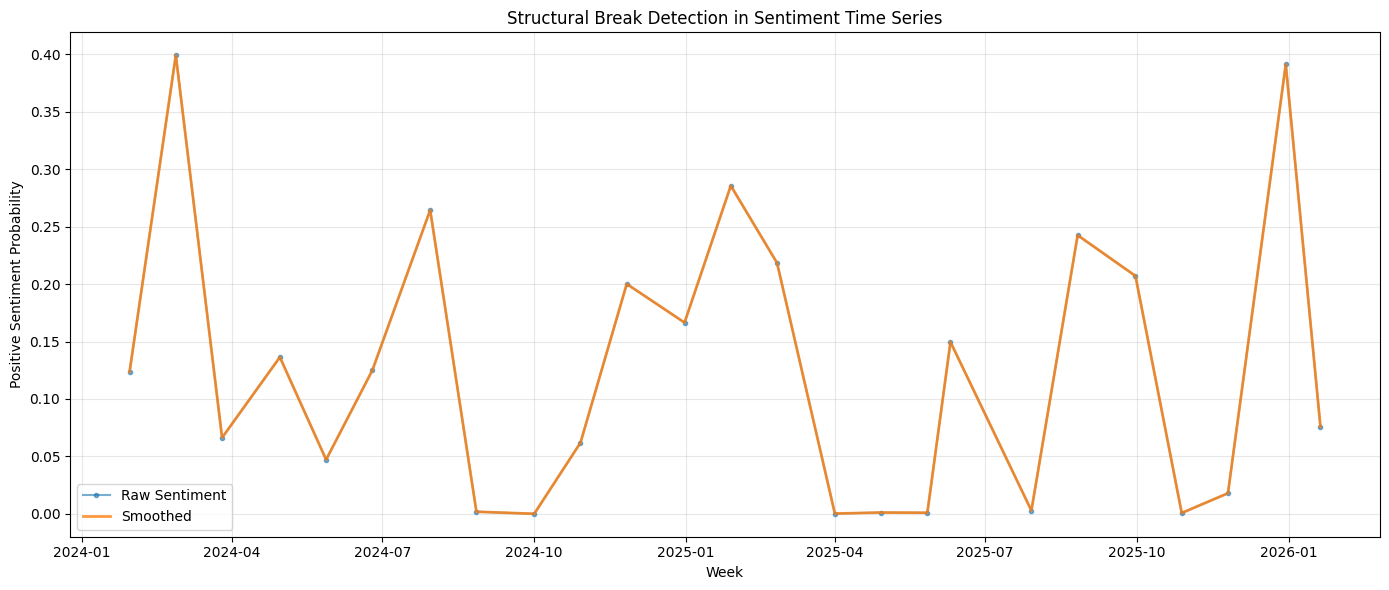

In [ ]:
# ============================================================================
# 5. STRUCTURAL BREAK DETECTION
# ============================================================================
# INTERPRETATION: Are there any structural breaks in the sentiment time series?

if RUPTURES_AVAILABLE:
    # Prepare signal (drop NaN)
    signal = weekly_stats['mean_pos'].dropna().values
    
    if len(signal) > 10:  # Need sufficient data
        # Detect structural breaks using PELT algorithm
        algo = rpt.Pelt(model="rbf").fit(signal.reshape(-1, 1))
        breaks = algo.predict(pen=5)  # Penalty parameter
        
        # Convert break indices to dates
        break_indices = breaks[:-1]  # Last element is always end of series
        break_dates = weekly_stats['mean_pos'].dropna().index[break_indices]
        
        print(f"Detected {len(break_indices)} structural break(s):")
        for i, (idx, date) in enumerate(zip(break_indices, break_dates)):
            print(f"  Break {i+1}: {date.date()} (index {idx})")
        
        # Plot with breakpoints
        fig, ax = plt.subplots(figsize=(14, 6))
        ax.plot(weekly_stats.index, weekly_stats['mean_pos'], 'o-', alpha=0.6, label='Raw Sentiment', markersize=3)
        ax.plot(weekly_stats.index, weekly_stats['smooth_lowess'], '-', linewidth=2, label='Smoothed', alpha=0.8)
        
        # Add vertical lines for breaks
        for date in break_dates:
            ax.axvline(date, color='red', linestyle='--', linewidth=1.5, alpha=0.7, label='Structural Break' if date == break_dates[0] else '')
        
        ax.set_xlabel('Week')
        ax.set_ylabel('Positive Sentiment Probability')
        ax.set_title('Structural Break Detection in Sentiment Time Series')
        ax.legend()
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    else:
        print("Insufficient data for structural break detection (need >10 weeks)")
else:
    print("Structural break detection requires 'ruptures' package. Install with: pip install ruptures")

Robustness Checks: Comparing Different Aggregation Methods

Correlation Matrix:
                     mean  median  long_articles_only  diverse_outlets  \
mean                1.000   0.588               0.990            1.000   
median              0.588   1.000               0.538            0.312   
long_articles_only  0.990   0.538               1.000            0.990   
diverse_outlets     1.000   0.312               0.990            1.000   
weighted            0.925   0.578               0.910            0.967   

                    weighted  
mean                   0.925  
median                 0.578  
long_articles_only     0.910  
diverse_outlets        0.967  
weighted               1.000  

Mean absolute differences:
  Mean vs Median: 0.0862
  Mean vs Long Articles: 0.0067
  Mean vs Diverse Outlets: 0.0000
  Mean vs Weighted: 0.0323


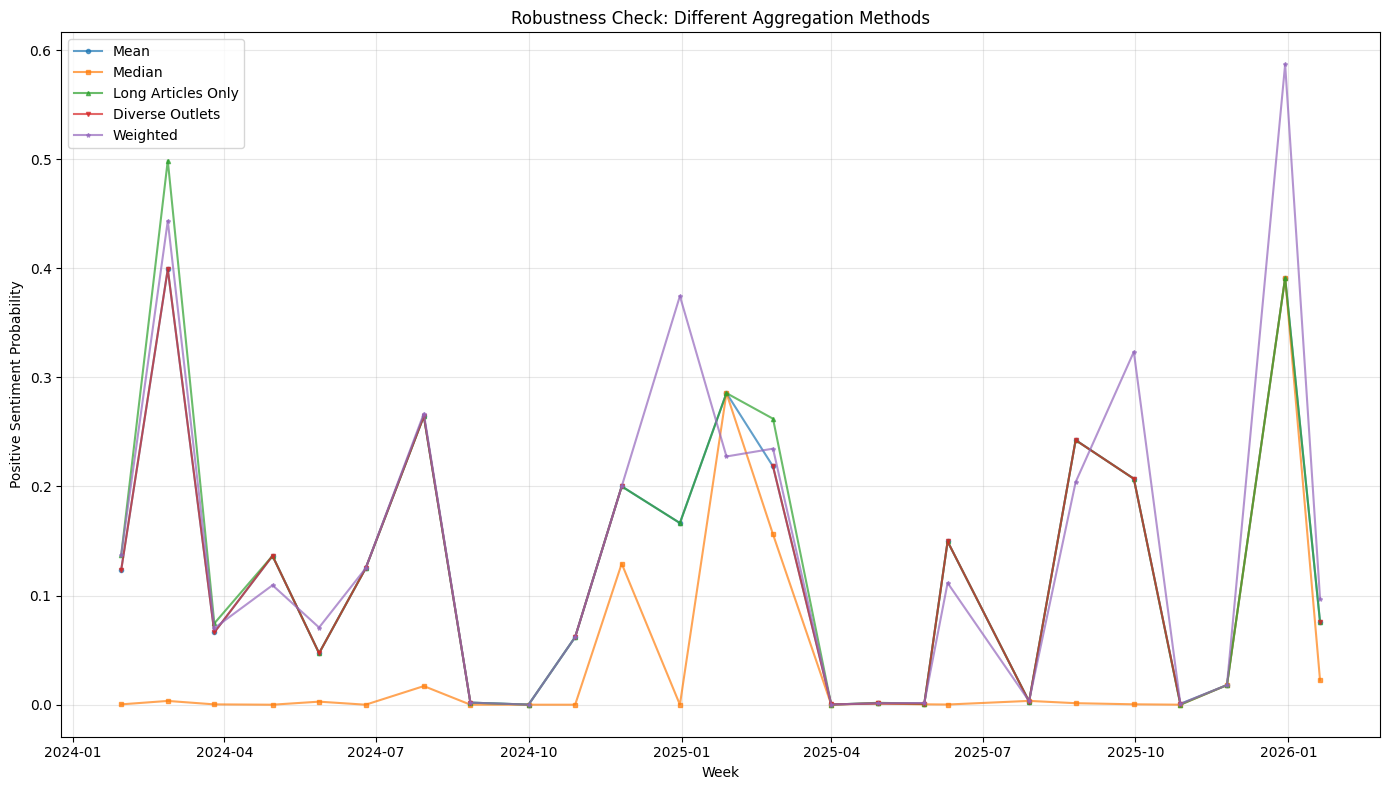

,mean,median,long_articles_only,diverse_outlets,weighted
week,,,,,
2024-01-30,0.1236,0.000320,0.137333,0.123646,0.137391
2024-02-27,0.3991,0.003460,0.498697,0.399111,0.443372
2024-03-26,0.0663,0.000303,0.074518,0.066317,0.070176
2024-04-30,0.1364,0.000004,0.136432,0.136432,0.109516
2024-05-28,0.0472,0.002797,0.047215,0.047215,0.070746
2024-06-25,0.1250,0.000002,0.125004,0.125004,0.125004
2024-07-30,0.2644,0.017061,0.264438,0.264438,0.266870
2024-08-27,0.0019,0.000029,0.001915,0.001915,0.001915
2024-10-01,0.0001,0.000002,0.000103,NaN,0.000095


In [ ]:
# ============================================================================
# 7. ROBUSTNESS CHECKS
# ============================================================================
# INTERPRETATION: How sensitive is the sentiment estimate to different aggregation methods?

print("Robustness Checks: Comparing Different Aggregation Methods\n")

# 1. Median instead of mean (robust to outliers)
weekly_median = df.groupby('week')['prob_positive'].median()

# 2. Exclude very short articles (n_pieces < 2)
df_long = df[df['n_pieces'] >= 2].copy()
weekly_long = df_long.groupby('week')['prob_positive'].mean()

# 3. Exclude weeks with high outlet concentration
df_diverse = df[~df['week'].isin(weekly_stats[weekly_stats['high_concentration']].index)].copy()
weekly_diverse = df_diverse.groupby('week')['prob_positive'].mean()

# 4. Weighted by article length
weekly_weighted_robust = df.groupby('week').apply(
    lambda g: np.average(g['prob_positive'], weights=g['weight'])
)

# Combine all variants
robustness_comparison = pd.DataFrame({
    'mean': weekly_stats['mean_pos'],
    'median': weekly_median,
    'long_articles_only': weekly_long,
    'diverse_outlets': weekly_diverse,
    'weighted': weekly_weighted_robust
})

# Compute correlations
print("Correlation Matrix:")
print(robustness_comparison.corr().round(3))
print(f"\nMean absolute differences:")
print(f"  Mean vs Median: {(robustness_comparison['mean'] - robustness_comparison['median']).abs().mean():.4f}")
print(f"  Mean vs Long Articles: {(robustness_comparison['mean'] - robustness_comparison['long_articles_only']).abs().mean():.4f}")
print(f"  Mean vs Diverse Outlets: {(robustness_comparison['mean'] - robustness_comparison['diverse_outlets']).abs().mean():.4f}")
print(f"  Mean vs Weighted: {(robustness_comparison['mean'] - robustness_comparison['weighted']).abs().mean():.4f}")

# Plot all variants
fig, ax = plt.subplots(figsize=(14, 8))
ax.plot(robustness_comparison.index, robustness_comparison['mean'], 'o-', label='Mean', alpha=0.7, markersize=3)
ax.plot(robustness_comparison.index, robustness_comparison['median'], 's-', label='Median', alpha=0.7, markersize=3)
ax.plot(robustness_comparison.index, robustness_comparison['long_articles_only'], '^-', label='Long Articles Only', alpha=0.7, markersize=3)
ax.plot(robustness_comparison.index, robustness_comparison['diverse_outlets'], 'v-', label='Diverse Outlets', alpha=0.7, markersize=3)
ax.plot(robustness_comparison.index, robustness_comparison['weighted'], '*-', label='Weighted', alpha=0.7, markersize=3)
ax.set_xlabel('Week')
ax.set_ylabel('Positive Sentiment Probability')
ax.set_title('Robustness Check: Different Aggregation Methods')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

robustness_comparison.head(10)

In [38]:
# ============================================================================
# 9. COMPREHENSIVE DIAGNOSTICS SUMMARY TABLE
# ============================================================================

# Calculate summary statistics
summary_stats = {
    'Metric': [
        'Mean Positive Sentiment',
        'Std Dev Positive Sentiment',
        'Mean CI Width (95%)',
        'Mean Articles per Week',
        'Weeks with <5 Articles',
        'Weeks with High Outlet Concentration (>40%)',
        'Mean Article Length (n_pieces)',
        'Total Articles Analyzed',
        'Date Range (weeks)',
        'Correlation: Weighted vs Unweighted',
        'Correlation: Mean vs Median',
    ],
    'Value': [
        f"{weekly_stats['mean_pos'].mean():.4f}",
        f"{weekly_stats['mean_pos'].std():.4f}",
        f"{weekly_stats['ci_width'].mean():.4f}",
        f"{weekly_stats['n_articles'].mean():.1f}",
        f"{(weekly_stats['n_articles'] < 5).sum()} ({(weekly_stats['n_articles'] < 5).mean()*100:.1f}%)",
        f"{weekly_stats['high_concentration'].sum()} ({weekly_stats['high_concentration'].mean()*100:.1f}%)",
        f"{df['n_pieces'].mean():.2f}",
        f"{len(df):,}",
        f"{len(weekly_stats)} weeks",
        f"{comparison['unweighted'].corr(comparison['weighted']):.4f}",
        f"{robustness_comparison['mean'].corr(robustness_comparison['median']):.4f}",
    ]
}

summary_df = pd.DataFrame(summary_stats)
print("=" * 70)
print("COMPREHENSIVE DIAGNOSTICS SUMMARY")
print("=" * 70)
print(summary_df.to_string(index=False))
print("=" * 70)

# Also create a formatted display
display(summary_df.style.set_properties(**{'text-align': 'left'}).set_table_styles([
    {'selector': 'th', 'props': [('text-align', 'left')]}
]))

COMPREHENSIVE DIAGNOSTICS SUMMARY
                                     Metric      Value
                    Mean Positive Sentiment     0.1275
                 Std Dev Positive Sentiment     0.1230
                        Mean CI Width (95%)     0.2689
                     Mean Articles per Week        5.6
                     Weeks with <5 Articles 10 (40.0%)
Weeks with High Outlet Concentration (>40%)  5 (20.0%)
             Mean Article Length (n_pieces)       2.43
                    Total Articles Analyzed        141
                         Date Range (weeks)   25 weeks
        Correlation: Weighted vs Unweighted     0.9254
                Correlation: Mean vs Median     0.5878


,Metric,Value
0,Mean Positive Sentiment,0.1275
1,Std Dev Positive Sentiment,0.1230
2,Mean CI Width (95%),0.2689
3,Mean Articles per Week,5.6
4,Weeks with <5 Articles,10 (40.0%)
5,Weeks with High Outlet Concentration (>40%),5 (20.0%)
6,Mean Article Length (n_pieces),2.43
7,Total Articles Analyzed,141
8,Date Range (weeks),25 weeks
9,Correlation: Weighted vs Unweighted,0.9254


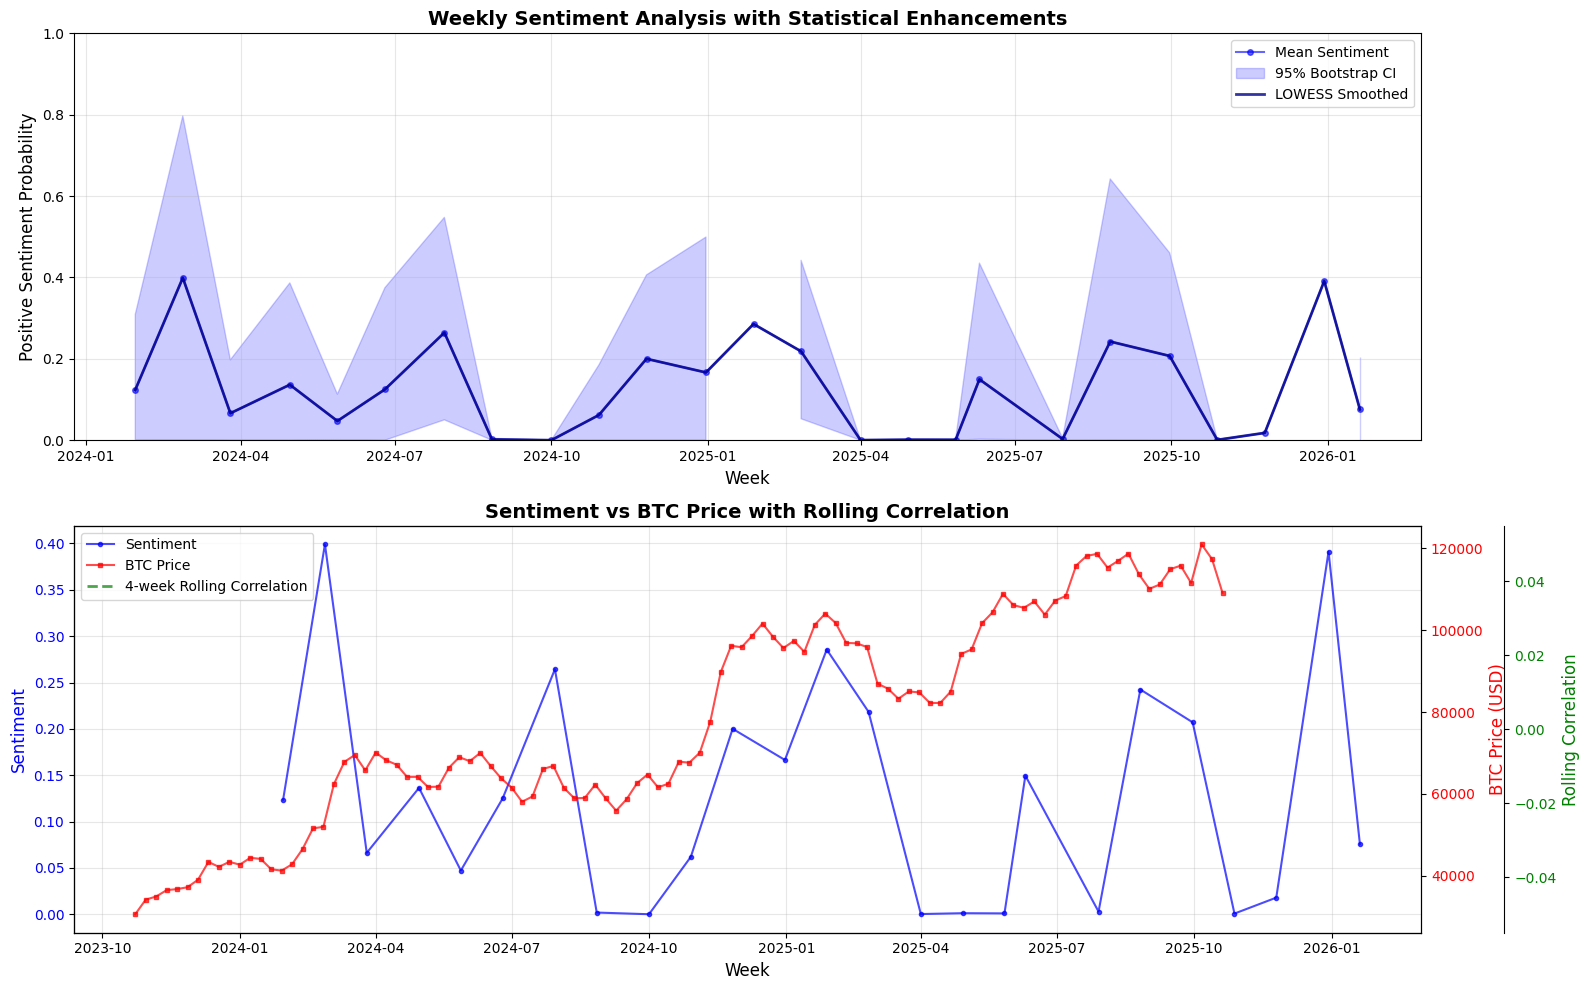


Enhanced visualization complete with:
  ✓ Bootstrap confidence intervals
  ✓ LOWESS smoothing
  ✓ Structural break indicators (if detected)
  ✓ Price correlation analysis


In [23]:
# ============================================================================
# 10. ENHANCED VISUALIZATION WITH CONFIDENCE INTERVALS
# ============================================================================

# Create publication-ready plot with all enhancements
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10))

# Top panel: Sentiment with confidence intervals and smoothing
ax1.plot(weekly_stats.index, weekly_stats['mean_pos'], 'o-', color='blue', 
         label='Mean Sentiment', alpha=0.6, markersize=4)
ax1.fill_between(weekly_stats.index, weekly_stats['ci_low'], weekly_stats['ci_high'], 
                 alpha=0.2, color='blue', label='95% Bootstrap CI')
ax1.plot(weekly_stats.index, weekly_stats['smooth_lowess'], '-', 
         color='darkblue', linewidth=2, label='LOWESS Smoothed', alpha=0.8)

# Add structural breaks if detected
if RUPTURES_AVAILABLE and 'break_dates' in locals() and len(break_dates) > 0:
    for date in break_dates:
        ax1.axvline(date, color='red', linestyle='--', linewidth=1.5, alpha=0.7)

ax1.set_xlabel('Week', fontsize=12)
ax1.set_ylabel('Positive Sentiment Probability', fontsize=12)
ax1.set_title('Weekly Sentiment Analysis with Statistical Enhancements', fontsize=14, fontweight='bold')
ax1.legend(loc='best', fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.set_ylim([0, 1])

# Bottom panel: Sentiment vs Price with correlation
ax2_twin = ax2.twinx()
line1 = ax2.plot(weekly_stats.index, weekly_stats['mean_pos'], 'b-o', 
                 label='Sentiment', alpha=0.7, markersize=3)
line2 = ax2_twin.plot(btc_weekly.index, btc_weekly, 'r-s', 
                      label='BTC Price', alpha=0.7, markersize=3)

# Calculate rolling correlation
# First, align btc_weekly with weekly_stats index
# Make both timezone-naive for alignment
weekly_stats_index_naive = weekly_stats.index
if weekly_stats.index.tz is not None:
    weekly_stats_index_naive = weekly_stats.index.tz_localize(None)

btc_weekly_aligned = btc_weekly.copy()
if btc_weekly_aligned.index.tz is not None:
    btc_weekly_aligned.index = btc_weekly_aligned.index.tz_localize(None)

# Reindex btc_weekly to match weekly_stats
btc_weekly_aligned = btc_weekly_aligned.reindex(weekly_stats_index_naive)

rolling_corr = pd.Series(index=weekly_stats_index_naive, dtype=float)
for i in range(4, len(weekly_stats)):
    window_sent = weekly_stats['mean_pos'].iloc[i-4:i]
    window_price = btc_weekly_aligned.iloc[i-4:i]
    # Only compute correlation if both windows have valid data
    if len(window_sent.dropna()) >= 2 and len(window_price.dropna()) >= 2:
        valid_mask = window_sent.notna() & window_price.notna()
        if valid_mask.sum() >= 2:
            rolling_corr.iloc[i] = window_sent[valid_mask].corr(window_price[valid_mask])

ax2_corr = ax2.twinx()
ax2_corr.spines['right'].set_position(('outward', 60))
line3 = ax2_corr.plot(rolling_corr.index, rolling_corr, 'g--', 
                      label='4-week Rolling Correlation', alpha=0.7, linewidth=2)

ax2.set_xlabel('Week', fontsize=12)
ax2.set_ylabel('Sentiment', color='b', fontsize=12)
ax2_twin.set_ylabel('BTC Price (USD)', color='r', fontsize=12)
ax2_corr.set_ylabel('Rolling Correlation', color='g', fontsize=12)
ax2.tick_params(axis='y', labelcolor='b')
ax2_twin.tick_params(axis='y', labelcolor='r')
ax2_corr.tick_params(axis='y', labelcolor='g')
ax2.set_title('Sentiment vs BTC Price with Rolling Correlation', fontsize=14, fontweight='bold')

lines = line1 + line2 + line3
labels = [l.get_label() for l in lines]
ax2.legend(lines, labels, loc='upper left', fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nEnhanced visualization complete with:")
print("  ✓ Bootstrap confidence intervals")
print("  ✓ LOWESS smoothing")
print("  ✓ Structural break indicators (if detected)")
print("  ✓ Price correlation analysis")